In [1]:
import os
import glob
import tensorflow as tf
import wave
import concurrent.futures
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
import random
import ast


2025-04-12 15:55:19.825718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 15:55:19.956920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744469720.009061   50945 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744469720.023771   50945 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-12 15:55:20.149949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# ---------------------------------------------------------
# 1. Define dataset directories and assign dataset IDs
# ---------------------------------------------------------
australia_dir = '/mnt/f/mars_global_acoustic_study/australia_acoustics/'
indonesia_dir = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
maldives_dir  = '/mnt/f/mars_global_acoustic_study/maldives_acoustics/'
mexico_dir    = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/'

# Dataset IDs: Australia = 1, Indonesia = 2, Maldives = 3, Mexico = 4

In [3]:
skip = "yes"

In [4]:
# ---------------------------------------------------------
# 2. Control variable for balancing:
#    Total samples per dataset (50/50 split for H and D).
# ---------------------------------------------------------
samples_per_class = 9000  # e.g., 500 H and 500 D per dataset

In [5]:
# ---------------------------------------------------------
# 3. Helper: Check if a WAV file is exactly 60 seconds long.
# ---------------------------------------------------------
def is_sixty_seconds_file(path):
    try:
        with wave.open(path, 'rb') as wf:
            frames = wf.getnframes()
            sr = wf.getframerate()
            return frames == sr * 60
    except Exception:
        return False

In [6]:
# ---------------------------------------------------------
# 4. Label extraction functions (Python version)
# ---------------------------------------------------------
import os

def extract_label_from_folder_py(file_path):
    # For datasets with subfolders.
    # Example file path: .../Degraded_Moth32/20230207_050000.WAV
    # We split on os.sep and take the parent folder (e.g. "Degraded_Moth32")
    parts = file_path.split(os.sep)
    if len(parts) < 2:
        return -1
    folder = parts[-2]
    # Use the first character of the folder name.
    if folder.startswith("H"):
        return 0
    elif folder.startswith("D"):
        return 1
    else:
        return -1

def extract_label_from_filename_py(file_path):
    # For Indonesia files.
    # Example file path: '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
    # Remove the prefix if it exists.
    prefix = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/'
    if file_path.startswith(prefix):
        file_path = file_path[len(prefix):]
    # Now file_path might look like "ind_D1_20220829_120000.WAV"
    parts = file_path.split('_')
    if len(parts) < 2:
        return -1
    # Take the first character of the second token, e.g., "D1" -> "D"
    if parts[1][0] == "H":
        return 0
    elif parts[1][0] == "D":
        return 1
    else:
        return -1

In [7]:
example_path = '/mnt/f/mars_global_acoustic_study/mexico_acoustics/H_M43/20230531_212400.WAV'
print(extract_label_from_folder_py(example_path))

0


In [8]:
# Example usage:
example_path = '/mnt/f/mars_global_acoustic_study/indonesia_acoustics/raw_audio/ind_D1_20220829_120000.WAV'
print(extract_label_from_filename_py(example_path))  # Expected output: 1

1


In [9]:
# ---------------------------------------------------------
# 5. Build a single file list for all datasets.
# ---------------------------------------------------------
import glob
import concurrent.futures
import random

def check_file(f, ds_id):
    if is_sixty_seconds_file(f):
        return f  # Return the file path if valid.
    return None

def get_files_for_dataset(root_dir, ds_id, samples_per_class):
    pos_files = []
    neg_files = []
    # Build the glob pattern (assumes a subfolder structure).
    if ds_id == 2:
        pattern = os.path.join(root_dir, "*.WAV")
    else:
        pattern = os.path.join(root_dir, "*", "*.WAV")
    files = glob.glob(pattern)
    print(f"Dataset {ds_id}: Total files found by glob: {len(files)}")
    # Shuffle the file list for random processing.
    random.shuffle(files)
    
    # Loop over the files until we have enough for both classes.
    for f in files:
        # Stop if we've collected enough files for both classes.
        if len(pos_files) >= samples_per_class and len(neg_files) >= samples_per_class:
            break
        
        # Check if the file is exactly 60 seconds long.
        if not is_sixty_seconds_file(f):
            continue
        
        # Extract the label depending on the dataset.
        if ds_id == 2:
            label = extract_label_from_filename_py(f)
        else:
            label = extract_label_from_folder_py(f)
        
        # Only add files with a valid label.
        if label == 1 and len(pos_files) < samples_per_class:
            pos_files.append((f, label, float(ds_id)))
        elif label == 0 and len(neg_files) < samples_per_class:
            neg_files.append((f, label, float(ds_id)))
    
    files_found = pos_files + neg_files
    random.shuffle(files_found)
    print(f"Dataset {ds_id}: Collected {len(files_found)} files (target was {2 * samples_per_class}).")
    return files_found

In [10]:
#files_australia = get_files_for_dataset(australia_dir, ds_id=1, samples_per_class=samples_per_class)
#with open("files_australia.txt", "w") as f:
#    for entry in files_australia:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [11]:
files_australia = []
with open("files_australia.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_australia.append(ast.literal_eval(line.strip()))

In [12]:
#files_maldives  = get_files_for_dataset(maldives_dir,  ds_id=3, samples_per_class=samples_per_class)
#with open("files_maldives.txt", "w") as f:
#    for entry in files_maldives:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [13]:
files_maldives = []
with open("files_maldives.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_maldives.append(ast.literal_eval(line.strip()))

In [14]:
#files_mexico    = get_files_for_dataset(mexico_dir,    ds_id=4, samples_per_class=samples_per_class)
#with open("files_mexico.txt", "w") as f:
#    for entry in files_mexico:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [15]:
files_mexico = []
with open("files_mexico.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_mexico.append(ast.literal_eval(line.strip()))

In [16]:
#files_indonesia = get_files_for_dataset(indonesia_dir, ds_id=2, samples_per_class=samples_per_class)
#with open("files_indonesia.txt", "w") as f:
#    for entry in files_indonesia:
#        # Write the string representation of each tuple on a new line.
#        f.write(str(entry) + "\n")

In [17]:
files_indonesia = []
with open("files_indonesia.txt", "r") as f:
    for line in f:
        # Strip newline characters and parse the string into a tuple.
        files_indonesia.append(ast.literal_eval(line.strip()))

In [18]:
# Combine file lists.
all_files = files_australia + files_indonesia + files_maldives + files_mexico
print(f"Total valid files: {len(all_files)}")

Total valid files: 160000


In [19]:
print("Sample files:")
for i, item in enumerate(all_files[:5]):
    print(item)

Sample files:
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth34/20230306_021600.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth35/20230307_071200.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth37/20230220_065600.WAV', 0, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Degraded_Moth33/20230216_074800.WAV', 1, 1.0)
('/mnt/f/mars_global_acoustic_study/australia_acoustics/Healthy_Moth36/20230218_095200.WAV', 0, 1.0)


In [20]:
# all_files is a list of tuples (file_path, ds_value)
pos_files = [item for item in all_files if item[1] == 1]
neg_files = [item for item in all_files if item[1] == 0]
x = [item for item in all_files if item[1] == -1]
print("Positive files count:", len(pos_files))
print("Negative files count:", len(neg_files))


Positive files count: 80000
Negative files count: 80000


In [21]:
# ---------------------------------------------------------
# 6. Create a tf.data.Dataset from the file list and extract labels.
# ---------------------------------------------------------
# Now, all_files is a list of tuples: (file_path, label, dataset_id)
file_paths = [f for f, label, ds in all_files]
labels = [label for f, label, ds in all_files]
ds_ids = [ds for f, label, ds in all_files]

# Create the dataset from a tuple of file_paths, ds_ids, and labels.
ds_all = tf.data.Dataset.from_tensor_slices((file_paths, ds_ids, labels))

def restructure(file_path, dataset_id, label):
    # Return a tuple in the format: ((file_path, dataset_id), label)
    return ((file_path, tf.cast(dataset_id, tf.float32)), label)

ds_all = ds_all.map(restructure, num_parallel_calls=tf.data.AUTOTUNE)

I0000 00:00:1744469724.027830   50945 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21458 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [22]:
if skip != "yes":    
    print("First sample (per label) from each dataset:")

    for ds_id in [1, 2, 3, 4]:
        for label_val in [0, 1]:
            # Filter ds_all for the current dataset ID and label.
            ds_filtered = ds_all.filter(lambda inputs, lbl: tf.logical_and(
                tf.equal(inputs[1], tf.cast(ds_id, tf.float32)),
                tf.equal(lbl, label_val)
            ))
            # Take the first element.
            sample = next(iter(ds_filtered.take(1)), None)
            if sample is None:
                print(f"Dataset {ds_id} | Label: {label_val} | No sample found.")
            else:
                ((file_path, dataset_id), lbl) = sample
                # Decode file_path if it is in bytes.
                file_path_str = file_path.numpy().decode('utf-8') if isinstance(file_path.numpy(), bytes) else file_path.numpy()
                print(f"Dataset {int(dataset_id.numpy())} | Label: {lbl.numpy()} | Filename: {file_path_str}")


In [23]:
if skip != "yes":
    def count_by_ds(ds, ds_id):
        ds_filtered = ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))
        count0 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 0)).reduce(0, lambda x, _: x+1)
        count1 = ds_filtered.filter(lambda inputs, label: tf.equal(label, 1)).reduce(0, lambda x, _: x+1)
        return count0.numpy(), count1.numpy()

    for ds_id in [1, 2, 3, 4]:
        c0, c1 = count_by_ds(ds_all, ds_id)
        print(f"Dataset {ds_id} - Healthy (0): {c0}, Degraded (1): {c1}")

In [24]:
# ---------------------------------------------------------
# 7. Balance the dataset per location.
#    We first split by dataset ID, then select samples_per_class per label for the balanced (train/val) set,
#    and assign the remaining examples as test data.
# ---------------------------------------------------------

def filter_by_ds(ds, ds_id):
    # The second element of inputs (index 1) is the dataset ID.
    return ds.filter(lambda inputs, label: tf.equal(inputs[1], tf.cast(ds_id, tf.float32)))

def balance_ds(ds):
    samples_per_label = samples_per_class  # Number of examples to take for each label
    balanced_list = []  # For balanced (train/val) set
    test_list = []      # For test set (the leftovers)
    
    for label_val in [0, 1]:
        # Filter examples by label value.
        ds_label = ds.filter(lambda inputs, label: tf.equal(label, label_val))
        # Take a fixed number for the balanced set.
        balanced_label = ds_label.take(samples_per_label)
        # Use the rest for testing.
        test_label = ds_label.skip(samples_per_label)
        
        balanced_list.append(balanced_label)
        test_list.append(test_label)
    
    # Combine the balanced samples for both classes
    balanced = balanced_list[0].concatenate(balanced_list[1])
    # Combine the test leftovers for both classes
    test = test_list[0].concatenate(test_list[1])
    # Final shuffle of the balanced set, if desired (you already use shuffle later).
    balanced = balanced.shuffle(2048)
    test = test.shuffle(2048)
    return balanced, test

# Build the datasets per location (ds_id).
balanced_datasets = []  # Will later be split to train/val.
test_datasets = []      # The leftovers that weren't used in balanced dataset.
for ds_id in [1, 2, 3, 4]:
    ds_filtered = filter_by_ds(ds_all, ds_id)
    balanced_subset, test_subset = balance_ds(ds_filtered)
    balanced_datasets.append(balanced_subset)
    test_datasets.append(test_subset)

In [25]:
def count_elements(ds):
    return sum(1 for _ in ds)

train_datasets = []
val_datasets = []
train_ratio = 0.7

# Split the balanced dataset from each location into train and validation sets.
for ds in balanced_datasets:
    # Separate by class.
    class_0 = ds.filter(lambda x, y: y == 0)
    class_1 = ds.filter(lambda x, y: y == 1)

    # Count samples (this is safe if the dataset is finite).
    count_0 = count_elements(class_0)
    count_1 = count_elements(class_1)

    # Split each class into training and validation.
    train_0 = class_0.take(int(train_ratio * count_0))
    val_0 = class_0.skip(int(train_ratio * count_0))

    train_1 = class_1.take(int(train_ratio * count_1))
    val_1 = class_1.skip(int(train_ratio * count_1))

    # Combine the split classes and shuffle again.
    train_ds = train_0.concatenate(train_1).shuffle(2048)
    val_ds = val_0.concatenate(val_1).shuffle(2048)

    train_datasets.append(train_ds)
    val_datasets.append(val_ds)

2025-04-12 15:55:30.539805: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 15:55:33.456557: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 15:55:43.773030: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 15:56:21.614614: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [26]:
if skip != "yes":      
    def count_elements(ds, label_val):
        return sum(1 for _, y in ds if y.numpy() == label_val)

    print("\n📊 Dataset Split Summary by Location:\n")

    for idx, (train_ds, val_ds) in enumerate(zip(train_datasets, val_datasets)):
        train_pos = count_elements(train_ds, 1)
        train_neg = count_elements(train_ds, 0)
        val_pos = count_elements(val_ds, 1)
        val_neg = count_elements(val_ds, 0)

        print(f"📍 Location {idx}:")
        print(f"  - Train: {train_pos + train_neg} samples (Pos: {train_pos}, Neg: {train_neg})")
        print(f"  - Val  : {val_pos + val_neg} samples (Pos: {val_pos}, Neg: {val_neg})\n")

In [27]:
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    
    target_sr = 16000
    orig_length = tf.shape(wav)[0]
    new_length = tf.cast(tf.cast(orig_length, tf.float32) *
                         (tf.cast(target_sr, tf.float32) / tf.cast(sample_rate, tf.float32)),
                         tf.int32)
    
    # Resize the audio by treating it as a 1-row image.
    wav_expanded = tf.expand_dims(tf.expand_dims(tf.expand_dims(wav, 0), 0), -1)
    wav_resized = tf.image.resize(wav_expanded, size=[1, new_length], method='bilinear')
    wav_resized = tf.squeeze(wav_resized, axis=[0, 1, 3])
    return wav_resized

def preprocess_mel(inputs, label):
    """
    inputs: a tuple (file_path, dataset_id)
    label: class label
    Returns: ((mel_spectrogram, extra_features), label)
    """
    file_path, dataset_id = inputs
    dataset_id = tf.cast(dataset_id, tf.float32)

    # 1. Load waveform (already 60 sec @ 16kHz, i.e. 960,000 samples)
    wav = load_wav_16k_mono(file_path)

    # 2. Compute STFT (fewer time frames for 60s audio)
    stfts = tf.signal.stft(wav, frame_length=1024, frame_step=640)
    spectrogram = tf.abs(stfts)  # shape ~ [1491, 513]

    # 3. Convert to mel scale
    num_spectrogram_bins = tf.shape(spectrogram)[-1]
    num_mel_bins = 64
    sample_rate = 16000
    lower_edge_hertz = 80.0
    upper_edge_hertz = 7600.0

    mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate,
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrogram = tf.tensordot(spectrogram, mel_weight_matrix, 1)
    mel_spectrogram.set_shape([None, num_mel_bins])  # allow dynamic time dim

    # 4. Log-scale and reshape
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=-1)  # [time, 64, 1]

    # 5. Extra features
    filename = tf.strings.split(file_path, os.sep)[-1]
    is_indonesia = tf.strings.regex_full_match(filename, r'^ind.*')

    def extract_time():
        parts = tf.strings.split(filename, '_')
        time_str = tf.strings.substr(parts[1], 0, 4)
        time_num = tf.strings.to_number(time_str, out_type=tf.float32)
        return time_num / 2359.0  # normalization example

    time_feature = tf.cond(is_indonesia,
                           lambda: tf.constant(0.0, dtype=tf.float32),
                           extract_time)
    dataset_feature = dataset_id / 4.0
    extra_features = tf.stack([time_feature, dataset_feature])  # shape: (2,)

    return {'spectrogram': mel_spectrogram, 'extra_features': extra_features}, label


In [28]:
final_train = train_datasets[0]
for ds in train_datasets[1:]:
    final_train = final_train.concatenate(ds)

In [29]:
final_val = val_datasets[0]
for ds in val_datasets[1:]:
    final_val = final_val.concatenate(ds)

In [30]:
batch_size = 16
# After you have your balanced_data from all concatenations and after preprocessing
final_train = final_train.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE)
final_train = final_train.cache()
#final_train = final_train.cache("train_cache.dat")
final_train = final_train.shuffle(buffer_size=2000)
final_train = final_train.repeat()
final_train = final_train.batch(batch_size)
final_train = final_train.prefetch(tf.data.AUTOTUNE)

In [31]:
final_val = final_val.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE)
final_val = final_val.cache()
final_val = final_val.repeat()
final_val = final_val.batch(batch_size)
final_val = final_val.prefetch(tf.data.AUTOTUNE)

In [32]:
train = final_train
val = final_val

In [33]:
samples, labels = train.as_numpy_iterator().next()

2025-04-12 15:56:32.092032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:102,RepeatDataset:103): Filling up shuffle buffer (this may take a while): 1764 of 2000
2025-04-12 15:56:33.315633: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-12 15:56:33.413381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [34]:
spectrograms_batch, extra_features_batch = samples
print(samples['spectrogram'][0].shape)        # → (1499, 64, 1)
print(samples['extra_features'][0].shape)     # → (2,)

(1499, 64, 1)
(2,)


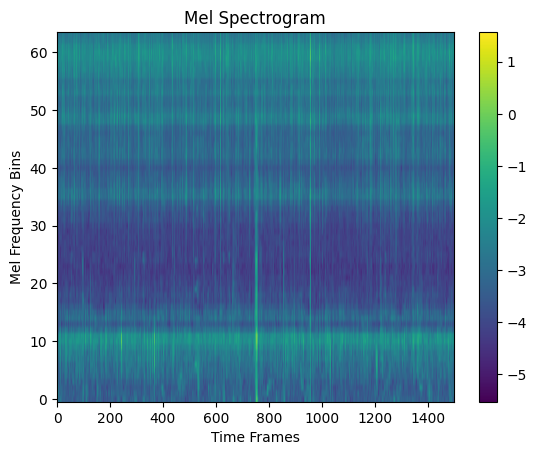

In [35]:
import matplotlib.pyplot as plt

# Access the spectrogram batch correctly from the dictionary
spectrograms_batch = samples['spectrogram']

# Plot the first spectrogram in the batch
plt.imshow(spectrograms_batch[0][:, :, 0].T, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.xlabel("Time Frames")
plt.ylabel("Mel Frequency Bins")
plt.show()


In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
    Dropout, GlobalAveragePooling2D, Dense, concatenate
)
import tensorflow as tf

def build_best_model():
    # Spectrogram input
    spect_input = Input(shape=(1499, 64, 1), name='spectrogram')

    # Block 1
    x = Conv2D(filters=16, kernel_size=(7, 7), padding='same')(spect_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.1)(x)

    # Block 2
    x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    # Block 3
    x = Conv2D(filters=96, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = GlobalAveragePooling2D()(x)

    # Extra features branch
    extra_input = Input(shape=(2,), name='extra_features')
    y = Dense(8, activation='relu')(extra_input)

    # Combine branches
    combined = concatenate([x, y])
    combined = Dense(32, activation='relu')(combined)
    combined = Dropout(0.3)(combined)

    output = Dense(1, activation='sigmoid')(combined)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    model = Model(inputs={'spectrogram': spect_input, 'extra_features': extra_input}, outputs=output)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall']
    )

    return model

# Build and optionally print summary
final_model = build_best_model()
final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram         │ (None, 1499, 64,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1499, 64,  │        800 │ spectrogram[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1499, 64,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1499, 64,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 749, 32,   │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 749, 32,   │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 749, 32,   │     18,560 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 749, 32,   │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 749, 32,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 374, 16,   │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 374, 16,   │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 374, 16,   │    110,688 │ dropout_1[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 374, 16,   │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 374, 16,   │          0 │ batch_normalizat… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 187, 8,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 187, 8,    │          0 │ max_pooling2d_2[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extra_features      │ (None, 2)         │          0 │ -               

 Total params: 134,425 (525.10 KB)

 Trainable params: 133,945 (523.22 KB)

 Non-trainable params: 480 (1.88 KB)

In [ ]:
train_batch = int(((samples_per_class*8)/batch_size)*0.8)
val_batch = int(((samples_per_class*8)/batch_size)*0.2)
print("Batches:", batch_size)
print("Batches for training", train_batch)
print("Batches for testing", val_batch)

Batches: 16
Batches for training 3150
Batches for testing 1350


In [38]:
# ---------------------------------------------------------
# 11. Train the model
# ---------------------------------------------------------
final_model = build_best_model()

hist = final_model.fit(train, epochs=10,steps_per_epoch=train_batch, validation_data=val, validation_steps=val_batch)

Epoch 1/10


2025-04-12 15:56:45.183536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] fused(ShuffleDatasetV3:102,RepeatDataset:103): Filling up shuffle buffer (this may take a while): 1681 of 2000
2025-04-12 15:56:46.519337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1744469806.568250   51047 service.cc:148] XLA service 0x7f07d8007100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744469806.568516   51047 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-12 15:56:46.621722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744469806.843951   51047 cuda_dnn.cc:529] Loaded cuDNN version 90501


   5/3150 ━━━━━━━━━━━━━━━━━━━━ 2:16 44ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.3304 - loss: 0.9847

I0000 00:00:1744469810.091533   51047 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3150/3150 ━━━━━━━━━━━━━━━━━━━━ 882s 275ms/step - Precision: 0.8867 - Recall: 0.8679 - accuracy: 0.9667 - loss: 0.1005 - val_Precision: 0.8943 - val_Recall: 0.5712 - val_accuracy: 0.7519 - val_loss: 1.3611
Epoch 2/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - Precision: 0.8948 - Recall: 0.8577 - accuracy: 0.9687 - loss: 0.1068 - val_Precision: 0.6507 - val_Recall: 0.6622 - val_accuracy: 0.6533 - val_loss: 1.1927
Epoch 3/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - Precision: 0.9053 - Recall: 0.8848 - accuracy: 0.9779 - loss: 0.0872 - val_Precision: 0.5660 - val_Recall: 0.9261 - val_accuracy: 0.6080 - val_loss: 2.1482
Epoch 4/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - Precision: 0.9128 - Recall: 0.9109 - accuracy: 0.9814 - loss: 0.0787 - val_Precision: 0.6449 - val_Recall: 0.7932 - val_accuracy: 0.6782 - val_loss: 0.9436
Epoch 5/10
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - Precision: 0.9258 - Recall: 0.9242 - accuracy: 0.9883 - loss: 0.0454 - val_Precision: 0.7721 - 

In [39]:
combined_test_ds = test_datasets[0]
for ds in test_datasets[1:]:
    combined_test_ds = combined_test_ds.concatenate(ds)

In [40]:
combined_test_ds = combined_test_ds.map(preprocess_mel, num_parallel_calls=tf.data.AUTOTUNE)
combined_test_ds = combined_test_ds.repeat()
combined_test_ds = combined_test_ds.batch(batch_size)
combined_test_ds = combined_test_ds.prefetch(tf.data.AUTOTUNE)

In [41]:
test = combined_test_ds

In [42]:
test_batch = len(all_files) - train_batch - val_batch


In [43]:
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
# 1. Predict directly from the val dataset (already batched and optimized)
y_pred_probs = final_model.predict(test.take(test_batch), verbose=0)

# 2. Collect true labels from val dataset
y_true = np.concatenate([labels.numpy() for _, labels in test.take(test_batch)])

# 3. Convert predicted probabilities to class predictions
y_pred = (y_pred_probs > 0.5).astype("int32")

# 4. Calculate metrics
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_probs)

# 5. Print results
print(f"Evaluation Metrics:")
print(f"F1 Score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (AUC = %.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR Curve
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# Precision
plt.plot(hist.history['Precision'], label='Training Precision')
plt.plot(hist.history['val_Precision'], label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision over Epochs')
plt.show()

In [ ]:
# Recall
plt.plot(hist.history['Recall'], label='Training Recall')
plt.plot(hist.history['val_Recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt